# Определение возраста покупателей

## Исследовательский анализ данных

**ОПИСАНИЕ ПРОЕКТА:**
Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

**Загрузим необходимые библиотеки и изучим данные**

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv2D, AvgPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Данные в коррекции не нуждаются

**Построим гистограмму распределения возраста**

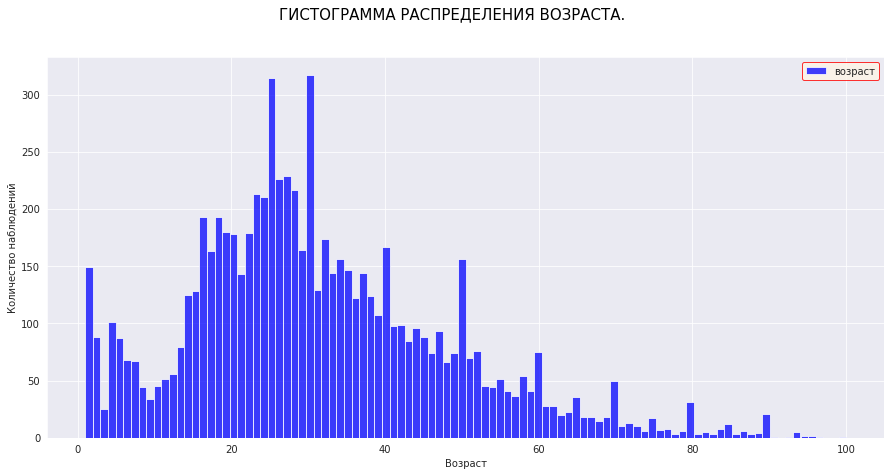

In [6]:
plt.figure(figsize=[15, 7])
plt.suptitle('ГИСТОГРАММА РАСПРЕДЕЛЕНИЯ ВОЗРАСТА.', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(data=labels['real_age'], color='b', label='возраст',bins=100, kde=False)
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.grid(True)
plt.legend(edgecolor = 'r', facecolor = 'oldlace')
plt.show();

**Определим размер выборки**

In [7]:
features, target = next(train_gen_flow)

In [8]:
print('Размер выборки -', features.shape)

Размер выборки - (32, 224, 224, 3)


**Выведем 15 фотографий на экран**

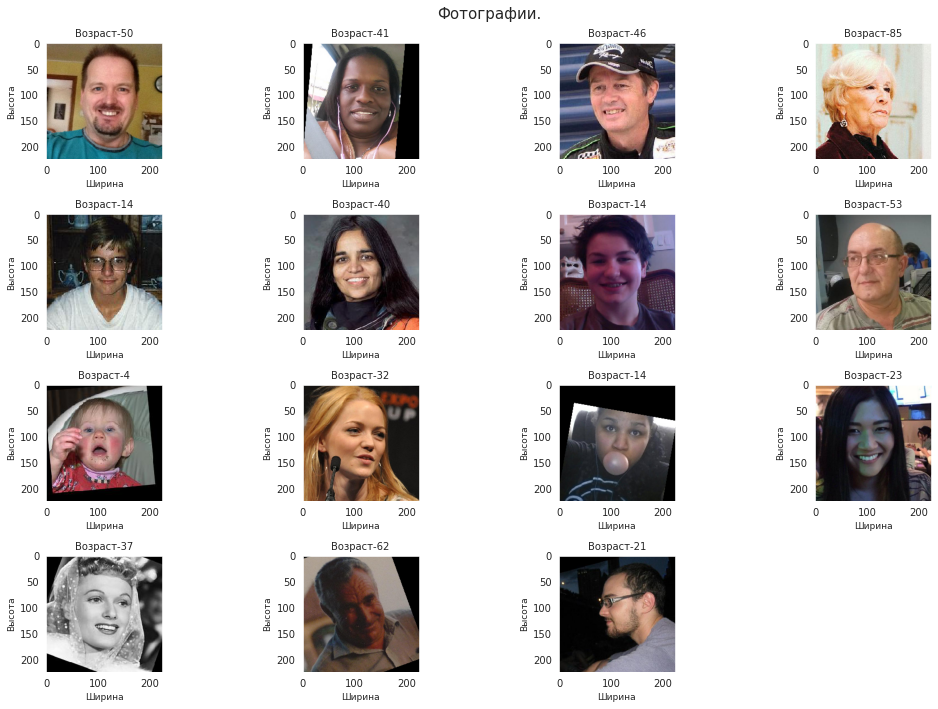

In [9]:
fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.95)
for i in range(15):
    plt.suptitle('Фотографии.', fontsize=15)
    fig.add_subplot(4,4, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.grid(False)
    plt.ylabel('Высота', fontsize=9)
    plt.xlabel('Ширина', fontsize=9)
plt.tight_layout()

**ВЫВОДЫ:**
- В датасете 7591 фотографий
- БОльшая часть фотографий возраста людей находится в диапазоне от 21 до 40 лет. После отметки 70 лет данных мало, есть выбросы, это может негативно отразиться в будущем на качестве обучения модели.
- Для разных категорий количество фотографий не одинаково. Это таже негативно отразится на обучении модели. Встречаются и цветные, и ЧБ фотографии, лица разного размера, под разными углами, анфас и в профиль, с посторонними предметами (микрофон, жвачка).

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 horizontal_flip=True,
                                 rescale=1./255)
   
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255)
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model,
                train_data,
                test_data,
                batch_size=None,
                epochs=10,
                steps_per_epoch=None,
                validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-02-21 10:26:37.689601: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-21 10:26:38.100399: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 243.0780 - mae: 11.0469 - val_loss: 1098.2893 - val_mae: 28.5891
Epoch 2/10
178/178 - 40s - loss: 76.8805 - mae: 6.6024 - val_loss: 958.0853 - val_mae: 26.1708
Epoch 3/10
178/178 - 38s - loss: 49.2984 - mae: 5.3654 - val_loss: 446.8395 - val_mae: 15.6851
Epoch 4/10
178/178 - 40s - loss: 36.2441 - mae: 4.5381 - val_loss: 145.7762 - val_mae: 9.4626
Epoch 5/10
178/178 - 38s - loss: 25.6705 - mae: 3.8776 - val_loss: 79.6126 - val_mae: 6.8399
Epoch 6/10
178/178 - 40s - loss: 21.1282 - mae: 3.5047 - val_loss: 68.4445 - val_mae: 6.1552
Epoch 7/10
178/178 - 40s - loss: 16.9849 - mae: 3.1485 - val_loss: 65.3613 - val_mae: 6.1208
Epoch 8/10
178/178 - 38s - loss: 14.5794 - mae: 2.9312 - val_loss: 62.9911 - val_mae: 5.9544
Epoch 9/10
178/178 - 38s - loss: 11.7956 - mae: 2.6248 - val_loss: 62.0499 - val_mae: 5.7803
Epoch 10/10
178/178 - 38s - loss: 10.7139 - mae: 2.4834 - val_loss: 60.5190 - val_mae: 5.8471
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 60.5190 - mae: 5.8471
Test MAE: 5.8471

```

## Анализ обученной модели

- Для получения наилучшего качества модели мы использовали архитектуру RestNet50 с количеством эпох 10, аугментацию данных и алгоритм Adam с частотой обучения lr=0.0001.

- Значение метрики MAE < 8; поставленной цели мы достигли.

- В выборке содержится большее количество фотографий людей в диапазоне от 21 до 40 лет. После отметки 70 лет данных мало - это потенциально сужает способности нейросети и создает ограничения в точности за пределами лиц, заявленной категории

- Использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью.

- Погрешность в 7 лет не такая "значимая" при определении возраста (за исколючением ситуаций с продажей алкоголя).

- Полученная модель вполне может решить поставленную бизнесом задачу, но всегда есть куда развиваться.